In [2]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *


from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Opening BSCCM
Opened BSCCM


## Does the MI estimator correctly estimate MI for samples from a stationary process with known MI

stick to additive Gaussian noise, H(Y) can be computed analytically. The covariance matrix for p(y) is just the one for p(x) with sigma**2 * I added to it

In [3]:
# Compute a "true" reference covariance matrix
num_images = 5000
num_patches = 15000
# num_images = 1000
# num_patches = 1000
edge_crop = 32
# patch_size = 50
patch_size = 15
channel = 'LED119'
eigenvalue_floor = 1e-3


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_full_cov_mat(patches)
cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=eigenvalue_floor)
gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
cov_mat_stationary_pd = gp.get_cov_mat()
gp.fit(patches)
cov_mat_stationary_optimized = gp.get_cov_mat()


2023-10-26 09:22:11.180636: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 1515.34


Epoch 1: 100%|██████████| 1/1 [00:14<00:00, 14.80s/it]


Epoch 1: validation NLL: 4.27


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 2: validation NLL: 4.27


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 3: validation NLL: 4.24


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 4: validation NLL: 4.26


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 5: validation NLL: 4.27


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


Epoch 6: validation NLL: 4.26


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch 7: validation NLL: 4.28


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch 8: validation NLL: 4.26


### Now verify that mutual information estimates converge to the true value with increasing number of samples

In [6]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it
from encoding_information.models.gaussian_process import StationaryGaussianProcess

num_images = 10000
num_patches = 50000
# num_images = 1000
# num_patches = 1000
edge_crop = 24

patch_size = 12

channel = 'DPC_Right'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_full_cov_mat(patches)
gp = StationaryGaussianProcess(patches)
gp.fit(patches)
true_cov_mat_px = gp.get_cov_mat()
true_mean_px = np.mean(images)
samples = gp.generate_samples(num_samples=num_patches, sample_shape=patch_size, ensure_nonnegative=True)

### Verify that entrpoy and mutual information estimates are consistent: they converge to the correct value given enough samples
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 


This all uses additive gaussian noise, which has an easy analytic formula for h(y | x)

In [8]:
from encoding_information.models.gaussian_process import gaussian_likelihood
from encoding_information.models.pixel_cnn import PixelCNN

num_samples_to_use = np.array([10, 40, 160,])
num_bootstrap_samples = 10

# num_samples_to_use = np.array([10, 40, 160, 640, 2560, 10240])
# num_bootstrap_samples = 50

gaussian_sigma = 50
confidence_interval = 90


def gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=1e-3, optimize=True):
    num_train = max(2, min(1000, 0.1 * data.shape[0]))
    train_data = data[:num_train]
    test_data = data[num_train:]
    if stationary:
        gp = StationaryGaussianProcess(train_data, eigenvalue_floor=eigenvalue_floor)
        if optimize:
            num_val_samples = max(1, min(1000, 0.1 * train_data.shape[0]))
            gp.fit(train_data, num_val_samples=num_val_samples, verbose=False)
        nll_per_pixel = gp.compute_negative_log_likelihood(test_data, verbose=False)
        
    else:
        cov_mat = estimate_full_cov_mat(train_data)
        nll_per_pixel = -gaussian_likelihood(cov_mat, train_data.mean(), test_data).mean() / (data.shape[1] * data.shape[2])
    return nll_per_pixel

def pixelcnn_entropy_estimate(data):
    num_train = int(max(2, min(1000, 0.1 * data.shape[0])))
    num_val_samples = int(max(1, min(1000, 0.1 * num_train)))
    train_data = data[:num_train]
    test_data = data[num_train:]
    model = PixelCNN()
    model.fit(train_data, num_val_samples=num_val_samples, max_epochs=25, verbose=False)
    nll_per_pixel = model.compute_negative_log_likelihood(test_data)
    return nll_per_pixel


h_x_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_px) 
true_cov_mat_py = true_cov_mat_px + gaussian_sigma**2 * np.eye(patch_size**2)
h_y_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_py) 
# Constant conditional entropy for Gaussian noise
h_y_given_x_analytic = analytic_multivariate_gaussian_entropy(np.eye(patch_size**2) * gaussian_sigma**2) 
mi_analytic_per_pixel = (h_y_analytic - h_y_given_x_analytic) / np.log(2)

noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)


full_cov_h_y_estimates_mean = []
full_cov_h_y_estimates_conf_int = []
stationary_h_y_estimates_mean = []
stationary_h_y_estimates_conf_int = []
stationary_h_y_estimates_optimized_mean = []
stationary_h_y_estimates_optimized_conf_int = []
pixelcnn_h_y_estimates_mean = []
pixelcnn_h_y_estimates_conf_int = []


h_y_given_x_estimates_mean = []
h_y_given_x_estimates_conf_int = []


ev_floor = 1e0
for num_to_use in tqdm(num_samples_to_use):

    print('full covariance gp')
    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, ), confidence_interval=confidence_interval )
    full_cov_h_y_estimates_mean.append(mean)
    full_cov_h_y_estimates_conf_int.append(conf_int)

    print('stationary gp')
    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, ), confidence_interval=confidence_interval)
    stationary_h_y_estimates_mean.append(mean)
    stationary_h_y_estimates_conf_int.append(conf_int)

    print('optimized stationary gp')
    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, optimize=True), confidence_interval=confidence_interval )
    stationary_h_y_estimates_optimized_mean.append(mean)
    stationary_h_y_estimates_optimized_conf_int.append(conf_int)

    print('pixelcnn')
    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: pixelcnn_entropy_estimate(data), confidence_interval=confidence_interval )
    pixelcnn_h_y_estimates_mean.append(mean)
    pixelcnn_h_y_estimates_conf_int.append(conf_int)


    # estimate conditional entropy
    mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: estimate_conditional_entropy(data), confidence_interval=confidence_interval )
    h_y_given_x_estimates_mean.append(mean)
    h_y_given_x_estimates_conf_int.append(conf_int)


full_cov_h_y_estimates_conf_int = np.array(full_cov_h_y_estimates_conf_int)
full_cov_h_y_estimates_mean = np.array(full_cov_h_y_estimates_mean)
stationary_h_y_estimates_conf_int = np.array(stationary_h_y_estimates_conf_int)
stationary_h_y_estimates_mean = np.array(stationary_h_y_estimates_mean)
stationary_h_y_estimates_optimized_conf_int = np.array(stationary_h_y_estimates_optimized_conf_int)
stationary_h_y_estimates_optimized_mean = np.array(stationary_h_y_estimates_optimized_mean)

pixelcnn_h_y_estimates_conf_int = np.array(pixelcnn_h_y_estimates_conf_int)
pixelcnn_h_y_estimates_mean = np.array(pixelcnn_h_y_estimates_mean)

h_y_given_x_estimates_conf_int = np.array(h_y_given_x_estimates_conf_int)
h_y_given_x_estimates_mean = np.array(h_y_given_x_estimates_mean)


  0%|          | 0/3 [00:00<?, ?it/s]

full covariance gp
stationary gp
optimized stationary gp
pixelcnn


Computing loss: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


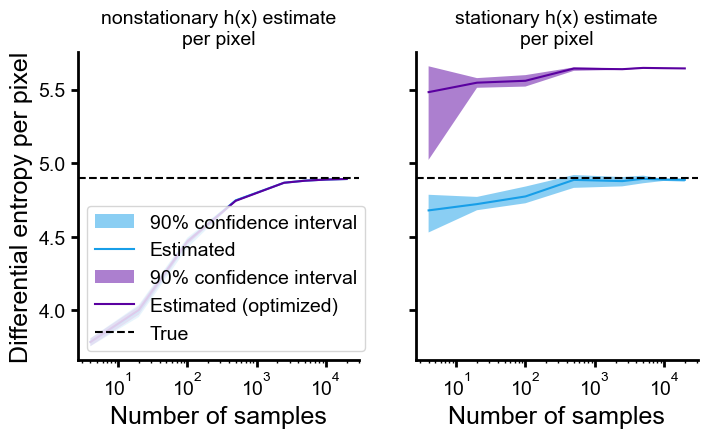

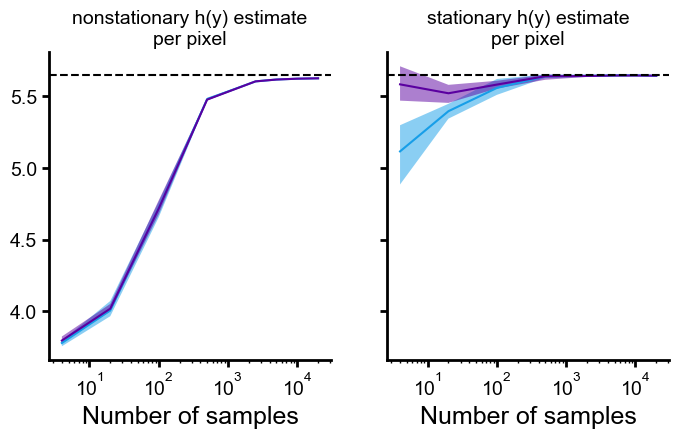

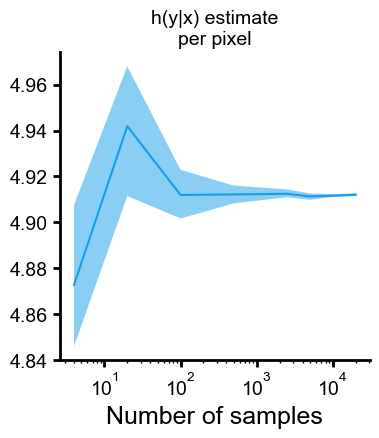

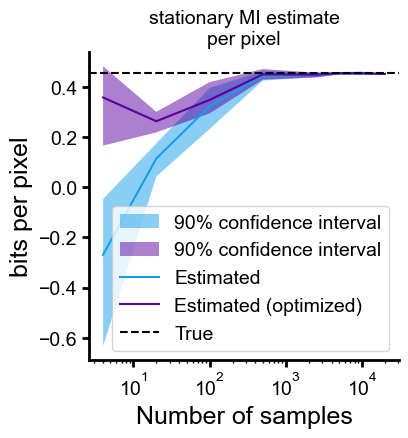

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
ax.axhline(h_y_analytic, color='k', linestyle='--')

ax.fill_between(num_samples_to_use, full_cov_h_y_estimates_conf_int[:,0], full_cov_h_y_estimates_conf_int[:,1], alpha=0.5)
ax.semilogx(num_samples_to_use, full_cov_h_y_estimates_mean, label='full covariance gp')

ax.fill_between(num_samples_to_use, stationary_h_y_estimates_conf_int[:,0], stationary_h_y_estimates_conf_int[:,1], alpha=0.5)
ax.semilogx(num_samples_to_use, stationary_h_y_estimates_mean, label='stationary gp')

ax.fill_between(num_samples_to_use, stationary_h_y_estimates_optimized_conf_int[:,0], stationary_h_y_estimates_optimized_conf_int[:,1], alpha=0.5)
ax.semilogx(num_samples_to_use, stationary_h_y_estimates_optimized_mean, label='optimized stationary gp')

ax.fill_between(num_samples_to_use, pixelcnn_h_y_estimates_conf_int[:,0], pixelcnn_h_y_estimates_conf_int[:,1], alpha=0.5)
ax.semilogx(num_samples_to_use, pixelcnn_h_y_estimates_mean, label='pixelcnn')

ax.set(xlabel='Number of samples', ylabel='Differential entropy')
ax.legend()
clear_spines(ax)


# conditional entropy
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, h_y_given_x_estimates_conf_int[:,0], h_y_given_x_estimates_conf_int[:,1], alpha=0.5)
ax.semilogx(num_samples_to_use, h_y_given_x_estimates_mean)
ax.set(xlabel='Number of samples', title='h(y|x) estimate\nper pixel')
clear_spines(ax)

